# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [42]:
#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'is_promoted'
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

# ATENÇÃO: nome do bucket criado no S3 (altere para o bucket com o seu nome)
bucket = 'aula-deploy-modelos-felipe-martins'

CAT = ['department'
,'education'
,'kpis_met_80']

NUM = ['no_of_trainings'
,'previous_year_rating'
,'length_of_service'
,'avg_training_score'
]
selected_features = CAT + NUM

# 2. Import Libraries

In [43]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

In [44]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [45]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='sa-east-1')

In [46]:
query4="select * from auladeploymodelos.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="auladeploymodelos", boto3_session=my_boto3_session)

In [47]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [48]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

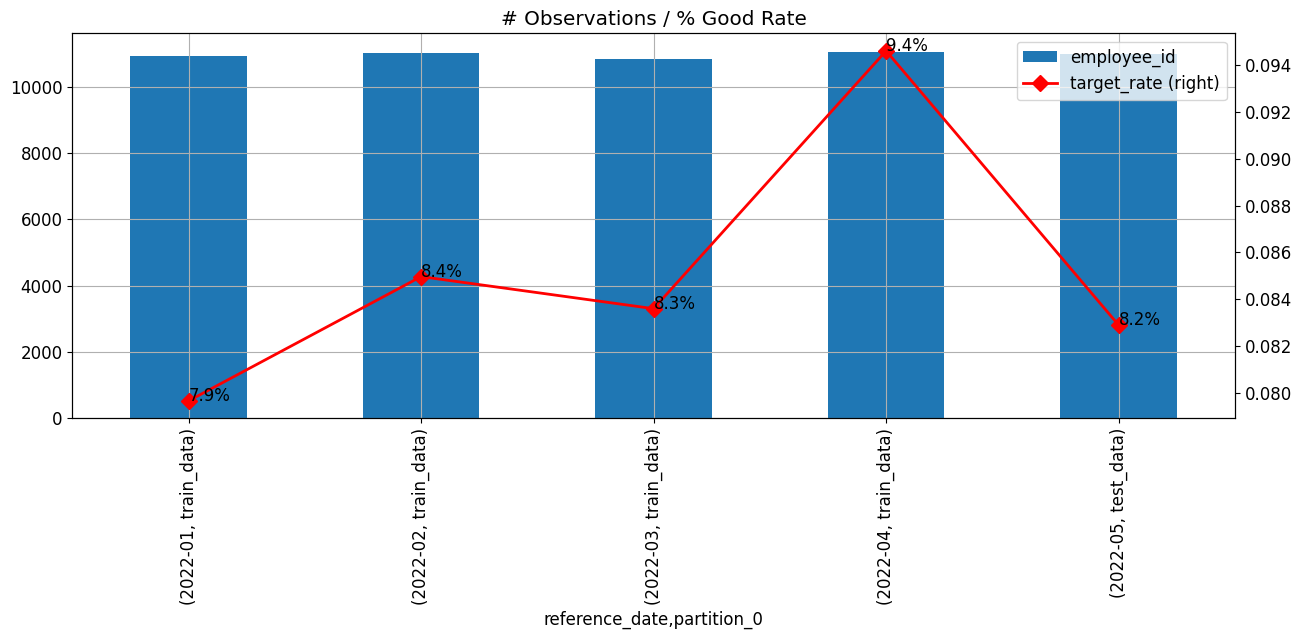

In [49]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'partition_0']].groupby(by=[VarDate, 'partition_0']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [50]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [51]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [52]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with SageMaker Autopilot

### 4.1.1 SageMaker Setup

In [53]:
# region = my_boto3_session.region_name
# session = sagemaker.Session(my_boto3_session)

# # You can modify the following to use a bucket of your choosing
# prefix = "models/%s/sagemaker-temp" % ModelName

# role = get_execution_role()

# # # This is the client we will use to interact with SageMaker AutoPilot
# sm = my_boto3_session.client(service_name="sagemaker", region_name=region)

# input_data_config = [
#     {
#         "DataSource": {
#             "S3DataSource": {
#                 "S3DataType": "S3Prefix",
#                 "S3Uri": 's3://%s/databases/%s/train_data/train_data.csv' % (bucket, ModelName),
#             }
#         },
#         "TargetAttributeName": 'Survived',
#     }
# ]

# output_data_config = {"S3OutputPath": "s3://%s/%s" % (bucket, prefix)}

### 4.1.2 SageMaker Setup and Run Auto Pilot

In [54]:
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())

# auto_ml_job_name = "autopilot-" + ModelName.replace('_', '-')[0:10] + '-' + timestamp_suffix
# print("AutoMLJobName: " + auto_ml_job_name)

# #Run SageMaker Autopilot
# sm.create_auto_ml_job(
#     AutoMLJobName=auto_ml_job_name,
#     InputDataConfig=input_data_config,
#     OutputDataConfig=output_data_config,
#     AutoMLJobConfig={"CompletionCriteria": {"MaxCandidates": 3}},
#     RoleArn=role
# )

In [55]:
# print("JobStatus - Secondary Status")
# print("------------------------------")

# describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
# print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime()))
# job_run_status = describe_response["AutoMLJobStatus"]

# while job_run_status not in ("Failed", "Completed", "Stopped"):
#     describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
#     job_run_status = describe_response["AutoMLJobStatus"]

#     print(
#         describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime())
#     )
#     sleep(30)

### 4.1.3 Create SageMaker Endpoint and Predictor with the Best Candidate

In [56]:
# #Select best candidate
# best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
# best_candidate_name = best_candidate["CandidateName"]

# #Add probability and probabilities to the SAGEMAKER_INFERENCE_OUTPUT
# for i in range(len(best_candidate["InferenceContainers"])):
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_INPUT']='predicted_label, probability, probabilities'
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_OUTPUT']='predicted_label, probability, probabilities'

# #Create endpoint configuration
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
# model_name = best_candidate_name + timestamp_suffix + "-model"
# model_arn = sm.create_model(
#     Containers=best_candidate["InferenceContainers"], ModelName=model_name, ExecutionRoleArn=role
# )

# epc_name = best_candidate_name + timestamp_suffix + "-epc"
# ep_config = sm.create_endpoint_config(
#     EndpointConfigName=epc_name,
#     ProductionVariants=[
#         {
#             "InstanceType": "ml.m5.2xlarge",
#             "InitialInstanceCount": 1,
#             "ModelName": model_name,
#             "VariantName": "main",
#         }
#     ],
# )

# #Create end endpoint
# ep_name = best_candidate_name + timestamp_suffix + "-ep"
# create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
# sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
# print("ep_name: " + str(ep_name))

In [57]:
# #Create Predictor
# sm_predictor = Predictor(
#     endpoint_name=ep_name,
#     sagemaker_session=session,
#     serializer=CSVSerializer(),
#     deserializer=CSVDeserializer(),
# )

## 4.2 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [58]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,8 mins 23 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 7 days !!!
H2O_cluster_name:,H2O_from_python_unknownUser_ut7nlt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [59]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 39382
Validation: 4436


In [60]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 10990


## 4.2.2 Train the H2O Champion algorithm with new data

In [61]:
# h2o_champion = h2o.load_model('StackedEnsemble_BestOfFamily_3_AutoML_1_20220713_190002')
# h2o_champion

In [62]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:27.616162

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_hr_analytics_v1_20221116_040000


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,109.0,109.0,18126.0,1.0,4.0,3.137615,1.0,15.0,8.513761




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.056781212947826586
RMSE: 0.23828808813666408
LogLoss: 0.19833346879186264
Mean Per-Class Error: 0.31569799275871746
AUC: 0.8895620161519254
AUCPR: 0.5432215266175497
Gini: 0.7791240323038509

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21304270294792704: 


,,0,1,Error,Rate
0,0,34944.0,1026.0,0.0285,(1026.0/35970.0)
1,1,2057.0,1355.0,0.6029,(2057.0/3412.0)
2,Total,37001.0,2381.0,0.0783,(3083.0/39382.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.213043,0.467806,168.0
1,max f2,0.107057,0.569906,270.0
2,max f0point5,0.291017,0.599120,131.0
3,max accuracy,0.291017,0.932990,131.0
4,max precision,0.991174,1.000000,0.0
5,max recall,0.014304,1.000000,380.0
6,max specificity,0.991174,1.000000,0.0
7,max absolute_mcc,0.263285,0.460468,142.0
8,max min_per_class_accuracy,0.125937,0.789566,248.0
9,max mean_per_class_accuracy,0.098728,0.808379,278.0



Gains/Lift Table: Avg response rate:  8.66 %, avg score:  8.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,0.762789,11.454319,11.454319,0.992386,0.925460,0.992386,0.925460,0.114596,0.114596,1045.431918,1045.431918,0.114512
1,2,0.020009,0.411355,9.989572,10.721946,0.865482,0.597695,0.928934,0.761578,0.099941,0.214537,898.957249,972.194583,0.212980
2,3,0.030090,0.274499,6.890434,9.438309,0.596977,0.322605,0.817722,0.614513,0.069461,0.283998,589.043412,843.830858,0.277993
3,4,0.040044,0.244052,4.740548,8.270571,0.410714,0.258107,0.716550,0.525920,0.047186,0.331184,374.054807,727.057102,0.318757
4,5,0.050505,0.229494,3.501882,7.282788,0.303398,0.236246,0.630970,0.465917,0.036635,0.367819,250.188228,628.278834,0.347414
5,6,0.100020,0.180837,2.551123,4.940380,0.221026,0.199145,0.428027,0.333852,0.126319,0.494138,155.112303,394.037977,0.431503
6,7,0.150246,0.161061,2.182399,4.018411,0.189080,0.169276,0.348149,0.278836,0.109613,0.603751,118.239853,301.841139,0.496523
7,8,0.200041,0.146143,1.854051,3.479657,0.160632,0.154081,0.301472,0.247782,0.092321,0.696073,85.405112,247.965657,0.543084
8,9,0.300188,0.116671,1.521792,2.826483,0.131846,0.129674,0.244882,0.208379,0.152403,0.848476,52.179160,182.648287,0.600297
9,10,0.400081,0.055500,1.088500,2.392539,0.094306,0.094769,0.207286,0.180013,0.108734,0.957210,8.849966,139.253860,0.609976




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.054666451742042176
RMSE: 0.23380857927382
LogLoss: 0.19029496452370842
Mean Per-Class Error: 0.2547376885988685
AUC: 0.8906153132184824
AUCPR: 0.4707754276607262
Gini: 0.7812306264369648

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16741932980486254: 


,,0,1,Error,Rate
0,0,3738.0,353.0,0.0863,(353.0/4091.0)
1,1,146.0,199.0,0.4232,(146.0/345.0)
2,Total,3884.0,552.0,0.1125,(499.0/4436.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.167419,0.443701,156.0
1,max f2,0.130950,0.564113,203.0
2,max f0point5,0.289613,0.504775,72.0
3,max accuracy,0.309811,0.933950,68.0
4,max precision,0.990294,1.000000,0.0
5,max recall,0.014628,1.000000,372.0
6,max specificity,0.990294,1.000000,0.0
7,max absolute_mcc,0.167419,0.397993,156.0
8,max min_per_class_accuracy,0.125207,0.797604,211.0
9,max mean_per_class_accuracy,0.065041,0.825277,275.0



Gains/Lift Table: Avg response rate:  7.78 %, avg score:  8.05 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010144,0.615866,12.000773,12.000773,0.933333,0.830875,0.933333,0.830875,0.121739,0.121739,1100.077295,1100.077295,0.121006
1,2,0.020063,0.310905,8.182345,10.113011,0.636364,0.397881,0.786517,0.616810,0.081159,0.202899,718.234519,911.301091,0.198254
2,3,0.030207,0.258180,4.285990,8.156176,0.333333,0.276815,0.634328,0.502633,0.043478,0.246377,328.599034,715.617564,0.234399
3,4,0.040352,0.238589,5.143188,7.398721,0.400000,0.246078,0.575419,0.438136,0.052174,0.298551,414.318841,639.872075,0.279973
4,5,0.050045,0.225267,2.990226,6.544823,0.232558,0.232575,0.509009,0.398320,0.028986,0.327536,199.022582,554.482308,0.300892
5,6,0.100090,0.177395,3.011777,4.778300,0.234234,0.195964,0.371622,0.297142,0.150725,0.478261,201.177699,377.830004,0.410062
6,7,0.150135,0.158839,2.664264,4.073621,0.207207,0.166580,0.316817,0.253621,0.133333,0.611594,166.426426,307.362145,0.500374
7,8,0.200180,0.142956,2.142995,3.590965,0.166667,0.150759,0.279279,0.227906,0.107246,0.718841,114.299517,259.096488,0.562400
8,9,0.300045,0.110966,1.596362,2.927096,0.124153,0.125532,0.227648,0.193832,0.159420,0.878261,59.636209,192.709633,0.626978
9,10,0.400361,0.045663,0.924618,2.425349,0.071910,0.081831,0.188626,0.165769,0.092754,0.971014,-7.538186,142.534926,0.618778




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.05782939197832383
RMSE: 0.2404774250908468
LogLoss: 0.20198799241283874
Mean Per-Class Error: 0.31606089612908506
AUC: 0.8798400125674612
AUCPR: 0.5190130626554501
Gini: 0.7596800251349225

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.201359097286642: 


,,0,1,Error,Rate
0,0,34570.0,1400.0,0.0389,(1400.0/35970.0)
1,1,2024.0,1388.0,0.5932,(2024.0/3412.0)
2,Total,36594.0,2788.0,0.0869,(3424.0/39382.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.201359,0.447742,183.0
1,max f2,0.099374,0.560440,280.0
2,max f0point5,0.299130,0.592790,133.0
3,max accuracy,0.299130,0.932507,133.0
4,max precision,0.993577,1.000000,0.0
5,max recall,0.014877,1.000000,379.0
6,max specificity,0.993577,1.000000,0.0
7,max absolute_mcc,0.299130,0.454843,133.0
8,max min_per_class_accuracy,0.123449,0.777550,255.0
9,max mean_per_class_accuracy,0.068093,0.805221,306.0



Gains/Lift Table: Avg response rate:  8.66 %, avg score:  8.62 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,0.744941,11.366434,11.366434,0.984772,0.914621,0.984772,0.914621,0.113716,0.113716,1036.643438,1036.643438,0.113549
1,2,0.020009,0.401235,10.077457,10.721946,0.873096,0.565535,0.928934,0.740078,0.100821,0.214537,907.745729,972.194583,0.212980
2,3,0.030014,0.281821,6.562065,9.335319,0.568528,0.324856,0.808799,0.601671,0.065651,0.280188,556.206521,833.531896,0.273905
3,4,0.040018,0.247536,3.486097,7.873014,0.302030,0.263064,0.682107,0.517019,0.034877,0.315064,248.609714,687.301351,0.301136
4,5,0.050023,0.228819,3.134558,6.925322,0.271574,0.238271,0.600000,0.461270,0.031360,0.346424,213.455794,592.532239,0.324517
5,6,0.100020,0.179950,2.473748,4.700100,0.214322,0.199523,0.407210,0.330429,0.123681,0.470106,147.374814,370.010033,0.405190
6,7,0.150196,0.159384,2.050260,3.814879,0.177632,0.168651,0.330516,0.276385,0.102872,0.572978,105.025992,281.487892,0.462886
7,8,0.200041,0.145390,1.752204,3.300912,0.151808,0.152664,0.285986,0.245557,0.087339,0.660317,75.220417,230.091211,0.503936
8,9,0.300036,0.115051,1.658935,2.753679,0.143728,0.129593,0.238575,0.206909,0.165885,0.826202,65.893536,175.367917,0.576077
9,10,0.400030,0.058573,1.251529,2.378189,0.108431,0.093435,0.206043,0.178544,0.125147,0.951348,25.152897,137.818929,0.603614




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.914961,0.006237,0.912530,0.906817,0.914931,0.923946,0.916582
1,auc,0.880222,0.007483,0.883987,0.881873,0.867579,0.887084,0.880586
2,err,0.085039,0.006237,0.087470,0.093183,0.085069,0.076054,0.083418
3,err_count,669.800000,49.159943,689.000000,734.000000,670.000000,599.000000,657.000000
4,f0point5,0.488456,0.028945,0.480639,0.459123,0.491924,0.535714,0.474882
5,f1,0.454580,0.026047,0.450996,0.457903,0.444444,0.495366,0.424189
6,f2,0.426151,0.033159,0.424797,0.456688,0.405324,0.460671,0.383275
7,lift_top_group,11.342172,0.426663,11.382948,10.850670,10.966582,11.790420,11.720238
8,logloss,0.201988,0.006493,0.201194,0.200699,0.212199,0.194115,0.201734
9,max_per_class_error,0.590412,0.039489,0.591040,0.544118,0.617143,0.559880,0.639881



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-11-16 04:00:23,22.909 sec,0.0,0.281305,0.294691,0.500000,0.086639,1.000000,0.913361,0.267960,0.273809,0.500000,0.077773,1.000000,0.922227
1,,2022-11-16 04:00:23,23.277 sec,5.0,0.272388,0.271225,0.790128,0.344690,9.705944,0.150729,0.260870,0.254657,0.792086,0.281583,8.571981,0.153291
2,,2022-11-16 04:00:23,23.558 sec,10.0,0.265650,0.255529,0.816944,0.367972,10.458291,0.150703,0.255207,0.240189,0.825107,0.298351,8.857713,0.170424
3,,2022-11-16 04:00:24,23.791 sec,15.0,0.261896,0.248805,0.818758,0.374209,10.487586,0.113859,0.252906,0.235349,0.824807,0.300466,9.429179,0.204013
4,,2022-11-16 04:00:24,23.942 sec,20.0,0.259050,0.242977,0.828474,0.388165,10.897715,0.129704,0.250835,0.230504,0.831184,0.314397,9.429179,0.169748
5,,2022-11-16 04:00:24,24.146 sec,25.0,0.257824,0.240111,0.827175,0.385673,10.897715,0.150576,0.249844,0.227682,0.831611,0.316265,9.429179,0.151488
6,,2022-11-16 04:00:24,24.326 sec,30.0,0.256843,0.237400,0.826932,0.384289,10.897715,0.196587,0.249088,0.225168,0.830689,0.315444,9.714911,0.142245
7,,2022-11-16 04:00:24,24.471 sec,35.0,0.254463,0.232488,0.834840,0.406634,11.073485,0.109974,0.247448,0.221307,0.837427,0.331156,9.714911,0.143823
8,,2022-11-16 04:00:25,24.644 sec,40.0,0.252747,0.228219,0.840687,0.421576,11.132075,0.114824,0.246213,0.217825,0.841090,0.343142,10.000644,0.139540
9,,2022-11-16 04:00:25,24.786 sec,45.0,0.252431,0.227018,0.839816,0.420758,11.073485,0.112640,0.245981,0.216791,0.839283,0.342162,10.000644,0.139991



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,avg_training_score,1897.835449,1.000000,0.480455
1,department,1005.202026,0.529657,0.254476
2,kpis_met_80,633.398071,0.333748,0.160351
3,previous_year_rating,347.530151,0.183119,0.087981
4,length_of_service,32.763542,0.017264,0.008294
5,education,21.790007,0.011482,0.005516
6,no_of_trainings,11.560105,0.006091,0.002927


## 4.2.3 Using H2O AutoML to performe all algorithms

In [72]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*15

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
04:33:35.426: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:15:01.496499



In [73]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_2_AutoML_3_20221116_43335,0.583346,0.899006,0.16604,0.314756,0.21994,0.0483736
StackedEnsemble_BestOfFamily_3_AutoML_3_20221116_43335,0.582862,0.898791,0.166133,0.312452,0.220035,0.0484153
GBM_5_AutoML_3_20221116_43335,0.581697,0.898216,0.170816,0.315506,0.221027,0.0488531
GBM_grid_1_AutoML_3_20221116_43335_model_2,0.579615,0.897164,0.170035,0.301446,0.220804,0.0487546
StackedEnsemble_BestOfFamily_4_AutoML_3_20221116_43335,0.577795,0.897202,0.167266,0.321503,0.220324,0.0485428
GBM_2_AutoML_3_20221116_43335,0.577315,0.89672,0.172718,0.318201,0.221353,0.0489971
GBM_3_AutoML_3_20221116_43335,0.576599,0.897135,0.173347,0.322846,0.221123,0.0488953
StackedEnsemble_AllModels_1_AutoML_3_20221116_43335,0.576584,0.896503,0.168788,0.320905,0.220896,0.0487952
StackedEnsemble_BestOfFamily_2_AutoML_3_20221116_43335,0.576228,0.896351,0.168923,0.322601,0.221002,0.0488419
XGBoost_grid_1_AutoML_3_20221116_43335_model_3,0.573689,0.895811,0.167184,0.316492,0.220785,0.0487461


In [74]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_2_AutoML_3_20221116_43335

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.04819720413378724
RMSE: 0.2195386164978436
LogLoss: 0.16309896135473698
Null degrees of freedom: 10038
Residual degrees of freedom: 10032
Null deviance: 6068.65814627125
Residual deviance: 3274.700946080409
AIC: 3288.700946080409
AUC: 0.9188219386248305
AUCPR: 0.6509167124899374
Gini: 0.837643877249661

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25958376283824613: 


,,0,1,Error,Rate
0,0,9009.0,128.0,0.014,(128.0/9137.0)
1,1,506.0,396.0,0.561,(506.0/902.0)
2,Total,9515.0,524.0,0.0632,(634.0/10039.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.259584,0.555400,129.0
1,max f2,0.128903,0.621492,249.0
2,max f0point5,0.368493,0.723855,90.0
3,max accuracy,0.368493,0.941727,90.0
4,max precision,0.999596,1.000000,0.0
5,max recall,0.007519,1.000000,373.0
6,max specificity,0.999596,1.000000,0.0
7,max absolute_mcc,0.327772,0.574104,102.0
8,max min_per_class_accuracy,0.135442,0.819963,240.0
9,max mean_per_class_accuracy,0.110452,0.833468,273.0



Gains/Lift Table: Avg response rate:  8.98 %, avg score:  8.77 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010061,0.995756,11.129712,11.129712,1.000000,0.998693,1.000000,0.998693,0.111973,0.111973,1012.971175,1012.971175,0.111973
1,2,0.020022,0.972472,11.129712,11.129712,1.000000,0.986654,1.000000,0.992703,0.110865,0.222838,1012.971175,1012.971175,0.222838
2,3,0.030083,0.637940,10.909321,11.056005,0.980198,0.894377,0.993377,0.959819,0.109756,0.332594,990.932142,1005.600505,0.332375
3,4,0.040044,0.317218,6.343936,9.883848,0.570000,0.405344,0.888060,0.821890,0.063193,0.395787,534.393570,888.384850,0.390862
4,5,0.050005,0.264679,3.338914,8.580077,0.300000,0.286588,0.770916,0.715256,0.033259,0.429047,233.891353,758.007659,0.416460
5,6,0.100010,0.191317,2.837855,5.708966,0.254980,0.216549,0.512948,0.465903,0.141907,0.570953,183.785479,470.896569,0.517435
6,7,0.150015,0.166090,1.840171,4.419368,0.165339,0.177806,0.397078,0.369870,0.092018,0.662971,84.017146,341.936761,0.563595
7,8,0.200020,0.148151,1.818001,3.769026,0.163347,0.157180,0.338645,0.316698,0.090909,0.753880,81.800072,276.902589,0.608537
8,9,0.300030,0.115110,1.463269,3.000440,0.131474,0.131974,0.269588,0.255123,0.146341,0.900222,46.326888,200.044022,0.659442
9,10,0.400040,0.035063,0.764891,2.441553,0.068725,0.083500,0.219373,0.212217,0.076497,0.976718,-23.510945,144.155280,0.633608




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.04709739791562689
RMSE: 0.21701934917335572
LogLoss: 0.15909543009458718
Null degrees of freedom: 4435
Residual degrees of freedom: 4429
Null deviance: 2429.229365131916
Residual deviance: 1411.4946557991775
AIC: 1425.4946557991775
AUC: 0.9052696091455616
AUCPR: 0.5576647092815432
Gini: 0.8105392182911233

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22057364485846387: 


,,0,1,Error,Rate
0,0,3974.0,117.0,0.0286,(117.0/4091.0)
1,1,200.0,145.0,0.5797,(200.0/345.0)
2,Total,4174.0,262.0,0.0715,(317.0/4436.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.220574,0.477759,127.0
1,max f2,0.095834,0.577198,275.0
2,max f0point5,0.740812,0.657718,43.0
3,max accuracy,0.740812,0.943868,43.0
4,max precision,0.999601,1.000000,0.0
5,max recall,0.012174,1.000000,361.0
6,max specificity,0.999601,1.000000,0.0
7,max absolute_mcc,0.740812,0.511609,43.0
8,max min_per_class_accuracy,0.126805,0.800538,235.0
9,max mean_per_class_accuracy,0.095834,0.834286,275.0



Gains/Lift Table: Avg response rate:  7.78 %, avg score:  7.91 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010144,0.984145,12.857971,12.857971,1.000000,0.994918,1.000000,0.994918,0.130435,0.130435,1185.797101,1185.797101,0.130435
1,2,0.020063,0.885744,12.273518,12.569028,0.954545,0.957015,0.977528,0.976179,0.121739,0.252174,1127.351779,1156.902785,0.251685
2,3,0.030207,0.348711,6.571852,10.555051,0.511111,0.557439,0.820896,0.835558,0.066667,0.318841,557.185185,955.505083,0.312974
3,4,0.040126,0.284823,2.922266,8.668295,0.227273,0.310136,0.674157,0.705678,0.028986,0.347826,192.226614,766.829507,0.333649
4,5,0.050045,0.241741,3.798946,7.703199,0.295455,0.262215,0.599099,0.617785,0.037681,0.385507,279.894598,670.319885,0.363752
5,6,0.100090,0.186276,2.780102,5.241650,0.216216,0.205813,0.407658,0.411799,0.139130,0.524638,178.010184,424.165035,0.460350
6,7,0.150135,0.161583,1.853401,4.112234,0.144144,0.173179,0.319820,0.332259,0.092754,0.617391,85.340123,311.223397,0.506660
7,8,0.200180,0.143655,2.142995,3.619924,0.166667,0.152630,0.281532,0.287352,0.107246,0.724638,114.299517,261.992427,0.568686
8,9,0.300045,0.107885,1.741486,2.994719,0.135440,0.125972,0.232908,0.233639,0.173913,0.898551,74.148592,199.471902,0.648978
9,10,0.400135,0.027784,0.839822,2.455691,0.065315,0.067485,0.190986,0.192077,0.084058,0.982609,-16.017757,145.569137,0.631594




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.049109531384742895
RMSE: 0.22160670428654206
LogLoss: 0.1687741831234931
Null degrees of freedom: 39381
Residual degrees of freedom: 39375
Null deviance: 23213.371820169312
Residual deviance: 13293.32975953881
AIC: 13307.32975953881
AUC: 0.8979717531967013
AUCPR: 0.5955650507595022
Gini: 0.7959435063934026

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3638965303817979: 


,,0,1,Error,Rate
0,0,35823.0,147.0,0.0041,(147.0/35970.0)
1,1,2160.0,1252.0,0.6331,(2160.0/3412.0)
2,Total,37983.0,1399.0,0.0586,(2307.0/39382.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.363897,0.520474,118.0
1,max f2,0.092270,0.576322,299.0
2,max f0point5,0.552469,0.710091,87.0
3,max accuracy,0.552469,0.942232,87.0
4,max precision,0.999634,1.000000,0.0
5,max recall,0.001720,1.000000,391.0
6,max specificity,0.999634,1.000000,0.0
7,max absolute_mcc,0.552469,0.558842,87.0
8,max min_per_class_accuracy,0.124097,0.788394,266.0
9,max mean_per_class_accuracy,0.059950,0.813233,327.0



Gains/Lift Table: Avg response rate:  8.66 %, avg score:  8.66 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,0.995953,11.542204,11.542204,1.000000,0.998718,1.000000,0.998718,0.115475,0.115475,1054.220399,1054.220399,0.115475
1,2,0.020009,0.968810,11.512909,11.527557,0.997462,0.986554,0.998731,0.992636,0.115182,0.230657,1051.290905,1052.755652,0.230629
2,3,0.030014,0.643030,10.546176,11.200430,0.913706,0.868154,0.970389,0.951142,0.105510,0.336166,954.617623,1020.042976,0.335193
3,4,0.040018,0.314533,4.335650,9.484235,0.375635,0.408579,0.821701,0.815501,0.043376,0.379543,333.565023,848.423487,0.371731
4,5,0.050048,0.266671,2.834415,8.151572,0.245570,0.286465,0.706240,0.709479,0.028429,0.407972,183.441465,715.157176,0.391875
5,6,0.100020,0.193012,2.152433,5.154287,0.186484,0.219732,0.446560,0.464792,0.107562,0.515533,115.243337,415.428708,0.454927
6,7,0.150018,0.165583,1.752727,4.020626,0.151854,0.177947,0.348341,0.369193,0.087632,0.603165,75.272676,302.062556,0.496132
7,8,0.200015,0.146235,1.735141,3.449327,0.150330,0.155689,0.298845,0.315824,0.086753,0.689918,73.514087,244.932692,0.536373
8,9,0.300010,0.109921,1.620833,2.839880,0.140427,0.127752,0.246043,0.253139,0.162075,0.851993,62.083261,183.988041,0.604342
9,10,0.400005,0.035145,1.143083,2.415708,0.099035,0.079333,0.209293,0.209690,0.114302,0.966295,14.308267,141.570790,0.620007




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.936596,0.004732,0.941504,0.935868,0.933819,0.941199,0.930591
1,auc,0.897962,0.003944,0.892472,0.902352,0.900099,0.899404,0.895481
2,err,0.063404,0.004732,0.058496,0.064132,0.066181,0.058801,0.069409
3,err_count,499.400000,37.553963,462.000000,501.000000,527.000000,462.000000,545.000000
4,f0point5,0.646142,0.062704,0.690846,0.615285,0.609512,0.732283,0.582784
5,f1,0.526955,0.016823,0.509554,0.532213,0.536500,0.547059,0.509451
6,f2,0.448155,0.029677,0.403633,0.468904,0.479108,0.436620,0.452510
7,lift_top_group,11.554486,0.413500,11.666174,11.908537,11.675953,10.837241,11.684524
8,logloss,0.168761,0.003775,0.170609,0.163363,0.166528,0.172820,0.170486
9,max_per_class_error,0.591574,0.038104,0.645495,0.565549,0.552786,0.615172,0.578869



See the whole table with table.as_data_frame()



## 4.3 Compare performance on the TEST dataset for all trained models

In [75]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(sm_predictor)
except NameError:
    pass
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [76]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


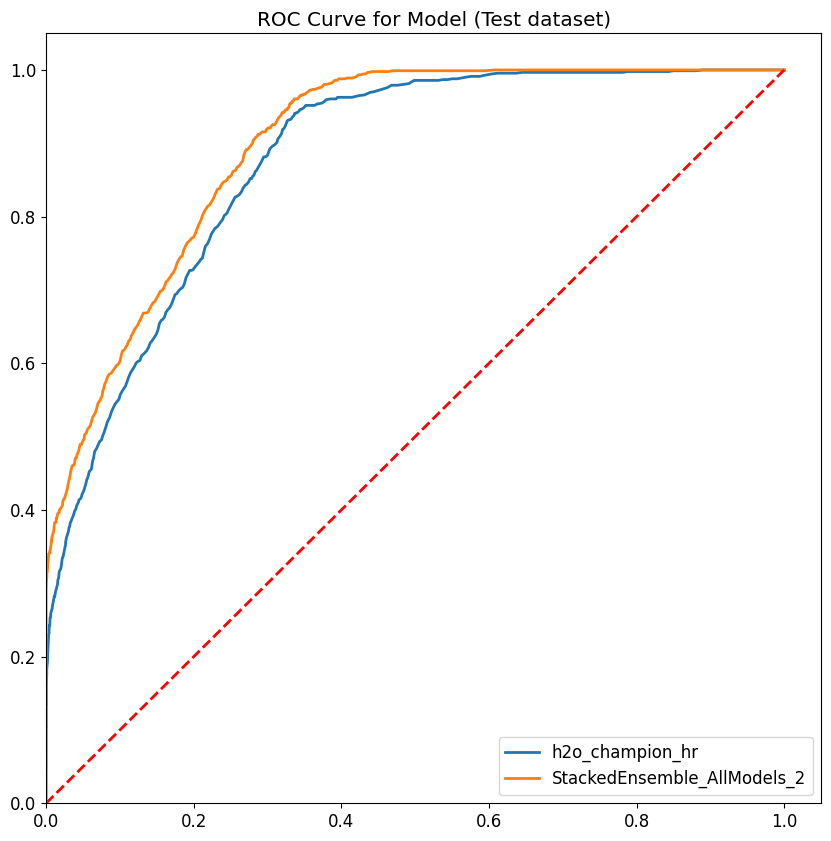

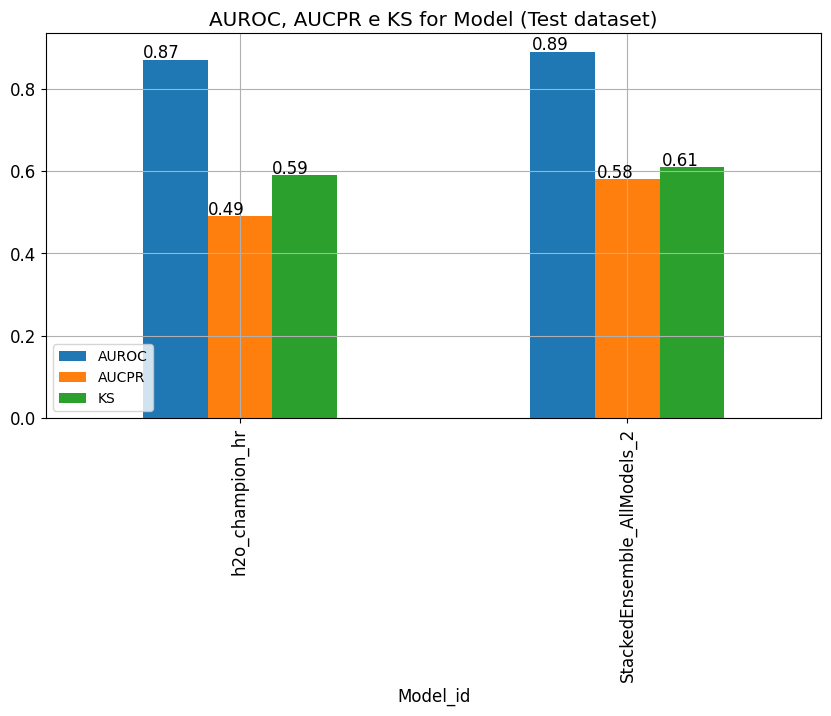

In [77]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [78]:
sort_metric_best_model='F1'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : F1


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,StackedEnsemble_AllModels_2_AutoML_3_20221116_43335,0.574816,0.899006,0.583346,0.166040,0.618,0.276715
1,0,GBM_3_AutoML_2_20221116_41915,0.369866,0.895161,0.570337,0.184850,0.614,0.256801
2,0,h2o_champion_hr_analytics_v1_20221116_040000,0.314228,0.876416,0.498060,0.198666,0.598,0.206124


In [79]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)    
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    print("Warning: This model doesn't have variable importances")


BEST MODEL: StackedEnsemble_AllModels_2_AutoML_3_20221116_43335

Variable importance plot is not available for this type of model (stackedensemble).

BEST MODEL: StackedEnsemble_AllModels_2_AutoML_3_20221116_43335



## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [80]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [81]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'Test_Dataset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'Test_Dataset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'Test_Dataset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'Test_Dataset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'Test_Dataset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


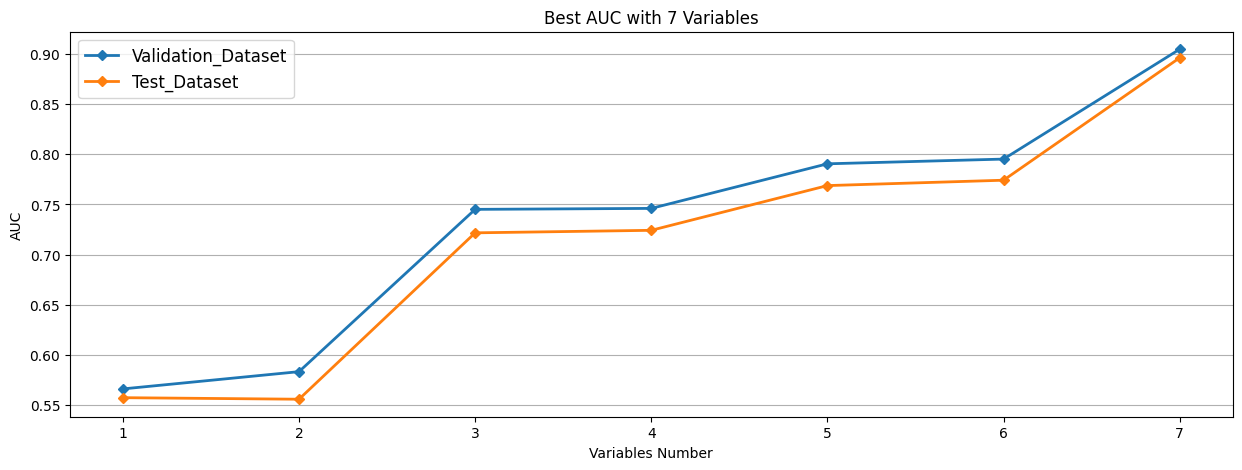

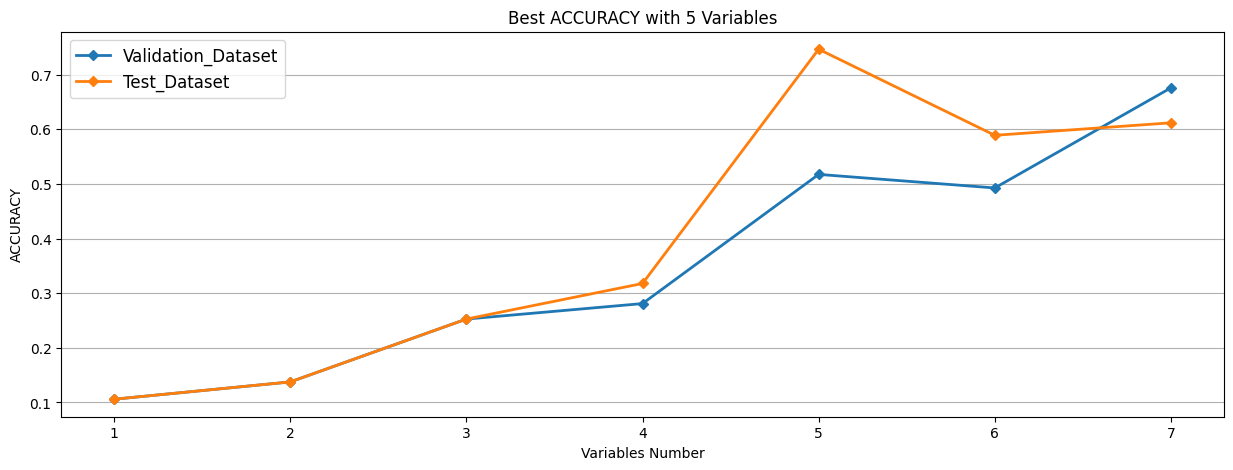

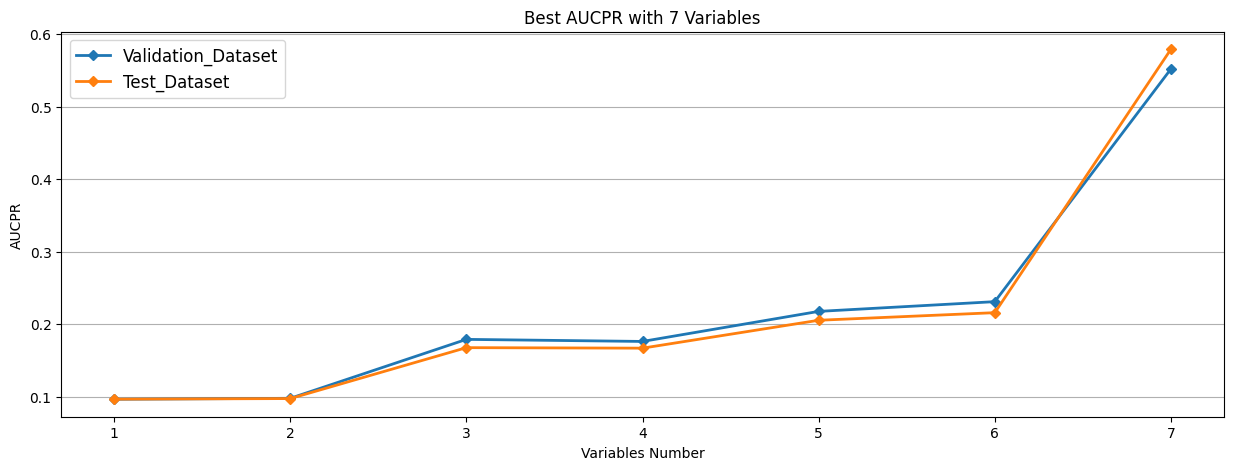

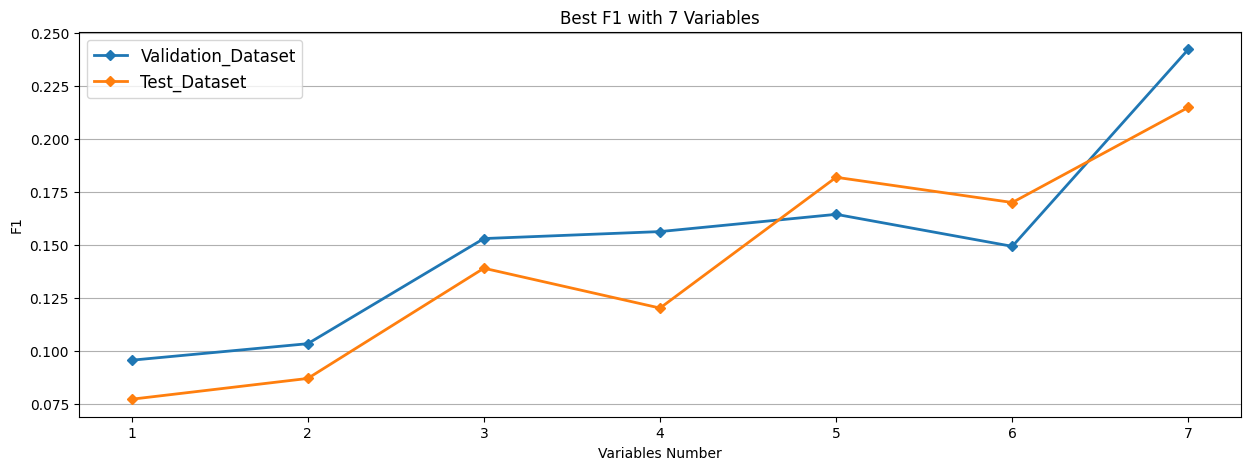

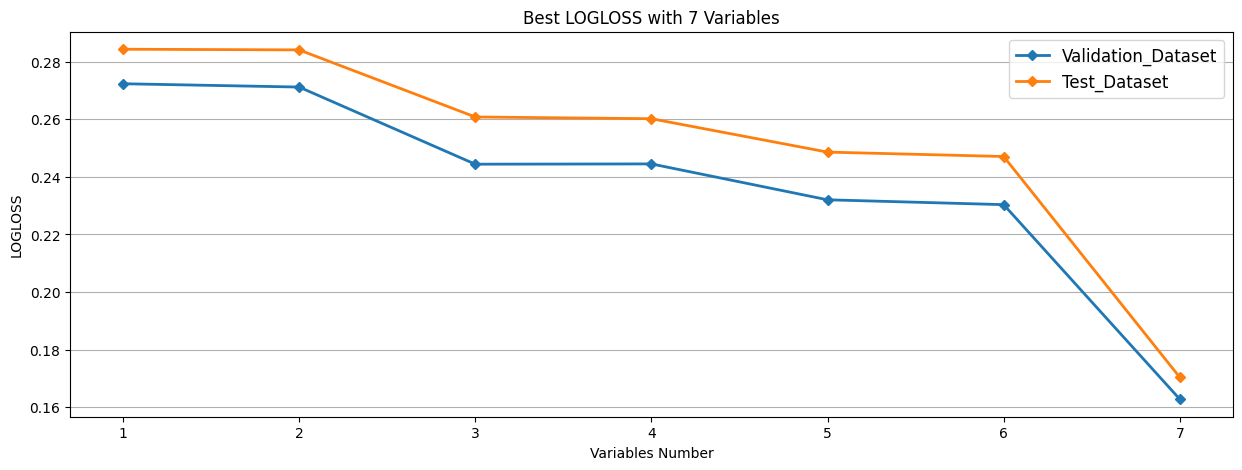

In [82]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [83]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['department', 'education', 'kpis_met_80', 'no_of_trainings', 'previous_year_rating', 'length_of_service', 'avg_training_score']


# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [84]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    src_path = "%s/models/candidates/%s.py" % (OutputPath, ModelId)
    dst_path = "%s/models/best/%s.py" % (OutputPath, ModelId)
    shutil.copy(src_path, dst_path)
    print('path_sagemaker_model: ' + str(dst_path))

path_model_mojo: /home/sagemaker-user/avaliacao/FIEP-Modelos-de-Aprendizado-e-Arquiteturas-Cloud/projeto_final/output_model/models/best/StackedEnsemble_AllModels_2_AutoML_3_20221116_43335.zip


Detected 1 unused columns in the input data set: {}


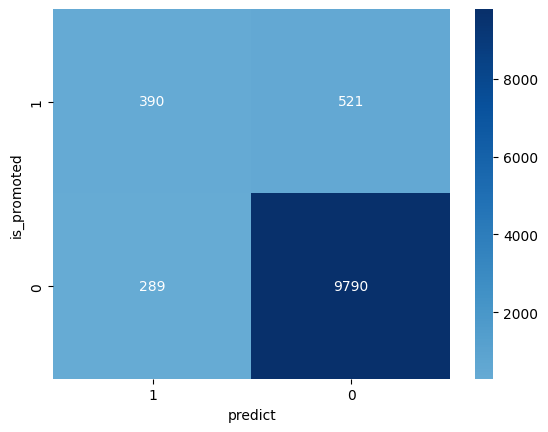

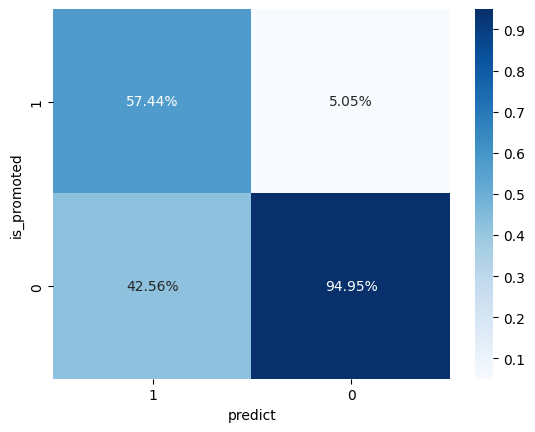

In [85]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 5.1 Cleaning Resources

In [86]:
# sm.delete_endpoint(EndpointName=ep_name)
# sm.delete_endpoint_config(EndpointConfigName=epc_name)

# 6. Save final dataset with predictions into S3 to explain the model

In [87]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [88]:
glue = my_boto3_session.client('glue', region_name="sa-east-1")

try:
    glue.delete_table(
        DatabaseName='auladeploymodelos',
        Name=ModelName+'_scored'
    )
except:
    print("table does not exist e sera criada pela primeira vez")

glue.update_crawler(Name='aula-deploy-modelos',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='aula-deploy-modelos')

table does not exist e sera criada pela primeira vez


{'ResponseMetadata': {'RequestId': '46f466d1-609c-4e44-b1f5-2fb1017db531',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 16 Nov 2022 05:09:05 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '46f466d1-609c-4e44-b1f5-2fb1017db531'},
  'RetryAttempts': 0}}